# Light GBM

In [1]:
import os
import sys

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from joblib import load
from lightgbm import LGBMRegressor

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

In [4]:
path_tuning = "./results_tuning"

## Light GBM

In [5]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = ["year", "month", "weekday", "hour"]

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        (
            "date",
            OneHotEncoder(handle_unknown="ignore", sparse=False),
            date_cols + add_date_cols,
        ),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
    ],
)

regressor = LGBMRegressor()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7fb488be2700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7fb488be25e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7fb488be2670>,
                                     kw_args={'dr...),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year', 'month', 'weekday',
                                                   'hour', 'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_name', 'wdir'])])),
                ('lgbmregressor', LGBMRegressor())])

In [6]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.58
Test set, RMSE=0.56


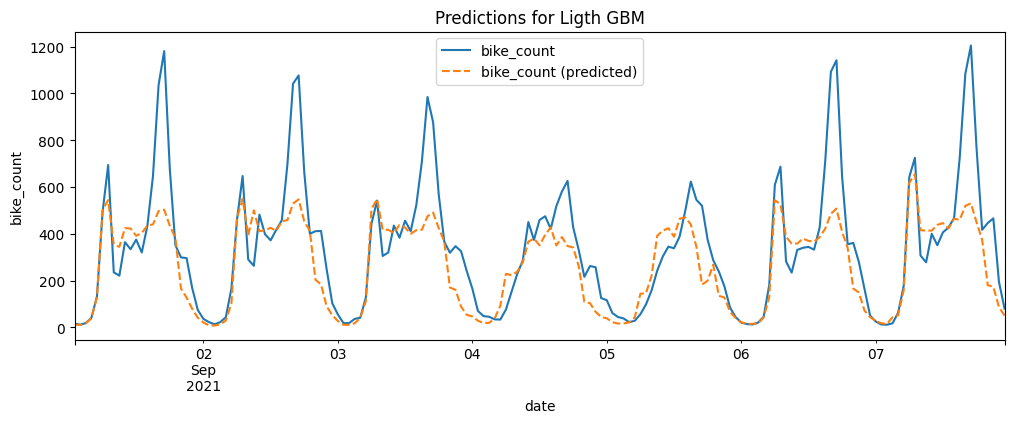

In [7]:
problem.week_plot(X_test, y_pred_test, y_test, "Ligth GBM")

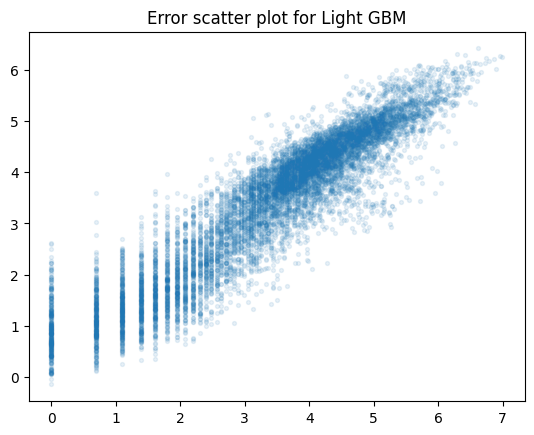

In [8]:
problem.error_plot(y_pred_test, y_test, "Light GBM")

## Tuned Light GBM

In [9]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221123_1810_tuning_lightGBM_cv_results.csv")
)
tuning_lightgbm = load(
    os.path.join(path_tuning, "20221123_1810_tuning_lightGBM_best_estimator.pkl")
)

In [10]:
y_pred_train = tuning_lightgbm.predict(X_train)
y_pred_test = tuning_lightgbm.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.45
Test set, RMSE=0.50


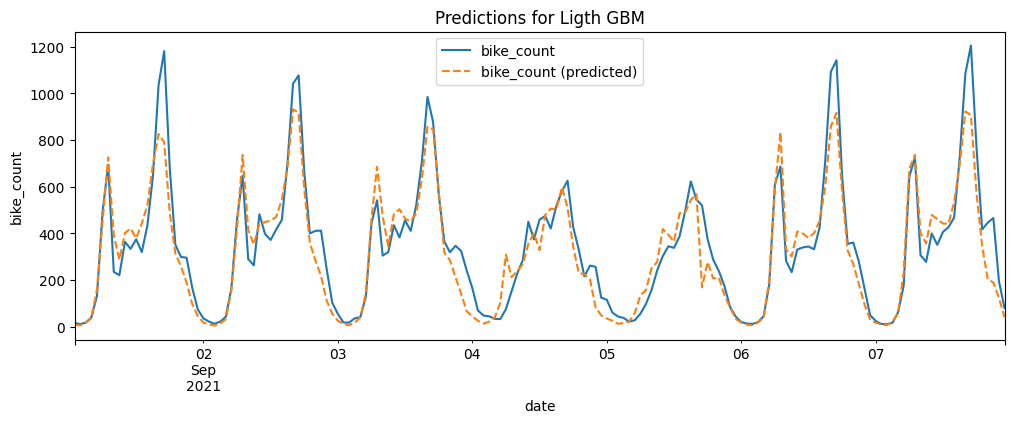

In [11]:
problem.week_plot(X_test, y_pred_test, y_test, "Ligth GBM")

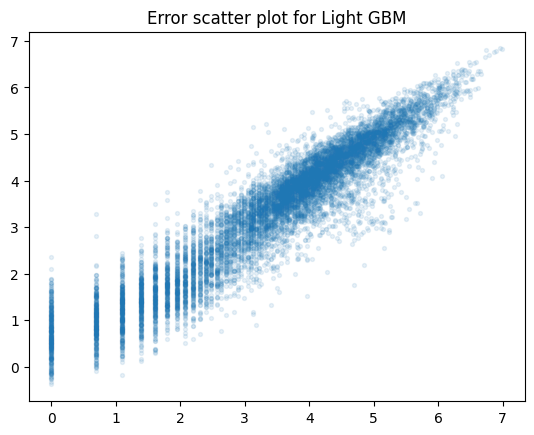

In [12]:
problem.error_plot(y_pred_test, y_test, "Light GBM")